### Import Libraries

In [49]:
# Most code adapted from Gabriel Weindel at https://github.com/GWeindel/hmp
import mne
import autoreject
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pathlib

### Load information from participant

In [34]:
data_path = pathlib.Path('D:/thesis/sat1')

subject_id = '0022'
subject_id_short = subject_id.replace('0', '')

In [ ]:
raw = mne.io.read_raw_brainvision(data_path / 'eeg4' / f'MD3-{subject_id}.vhdr', preload=False)
raw.set_channel_types({'EOGh':'eog', 'EOGv':'eog', 'A1':'misc', 'A2':'misc'}) # Declare type to avoid confusion with EEG channels
raw.rename_channels({'FP1':'Fp1', 'FP2':'Fp2'}) # Naming convention
raw.set_montage('standard_1020')# Standard 10-20 electrode montage
raw.rename_channels({'Fp1':'FP1', 'Fp2':'FP2'})
# raw.plot_sensors(ch_type='eeg')

Not setting metadata
200 matching events found
No baseline correction applied
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\Rick\anaconda3\envs\thesis\lib\site-packages\mne\viz\utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


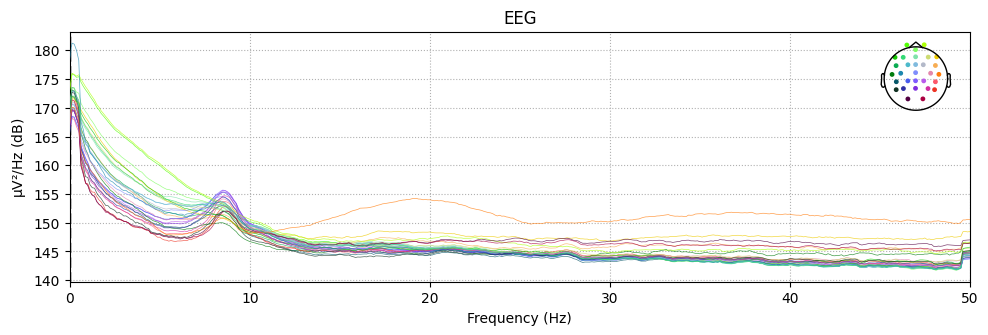

In [50]:
epochs = mne.io.read_epochs_fieldtrip(data_path / 'eeg1' / f'data{subject_id_short}.mat', info=raw.info)
%matplotlib inline
epochs.compute_psd(fmax=50).plot(picks='data', exclude='bads');